<a href="https://colab.research.google.com/github/darioromero/gasturbinedecay/blob/master/gas_turbine_keras_colab_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L1L2

# Helper libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

plt.style.use('ggplot')

print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [0]:
def getDataFrame():
    
    # read feature names
    data_features = [line.rstrip('\n').split('\t') for line in 
                     open('sample_data/features_new.txt')]
    
    # convert data_features in a list of column headers
    features = []
    for n, f in enumerate(data_features[0]):
        value = re.sub(r'(\[|\]|\(|\))*', '', str(f))
        features.append(value.strip().replace(" ", "_"))


    short_features = ['Lever_lp', 'Speed_knots', 'Gas_Turb_shaftTrq', 
                      'Gas_Turb_SpeedGT', 'Cntrl_PtchProp_Thrs', 
                      'Cntrl_PtchProp_ThrsN', 'Shaft_Trq_Prt', 
                      'Shaft_rpm_Prt', 'Shaft_Trq_Q', 
                      'Shaft_rpm_stbd', 'HP_Turb_temp', 
                      'Gnrtr_Gas_Speed', 'Fuel_Flow', 
                      'ABB_Tic_Cntrl', 'GT_Compr_RS', 
                      'GT_Compr_tmp', 'External_Prs', 
                      'HP_Turb_Prs', 'TCS_tic_Cntrl', 
                      'Thrst_coeff', 'Prop_stbd', 
                      'Thrst_coeff_Prt', 'Prop_Prt', 
                      'Prop_Trq_Prt', 'Prop_Trq', 
                      'Prop_Thrs_Decay_coeff', 'Prop_Trq_Decay_coeff', 
                      'Hull_Decay_coeff', 'GT_Compr_Decay_coeff', 
                      'GT_Turb_Decay_coeff']
    
    # read data file with no-headers
    data_lines = [line.rstrip('\n').split('\t') for line in 
                  open('sample_data/data_new.txt')]

    # create dataframe - print shape
    df = pd.DataFrame(data=data_lines, columns=short_features, dtype='float')

    return df

In [45]:
# get dataframe - print shape
df = getDataFrame()
print("\ndf(rows, cols): %s\n" % str(df.shape))


df(rows, cols): (589223, 30)



In [5]:
df.loc[df.GT_Turb_Decay_coeff == 1.0,'GT_Turb_Decay_coeff'].value_counts()

1.0    73675
Name: GT_Turb_Decay_coeff, dtype: int64

In [6]:
df.loc[df.GT_Turb_Decay_coeff == 0.99821,'GT_Turb_Decay_coeff'].value_counts()

0.99821    36820
Name: GT_Turb_Decay_coeff, dtype: int64

In [7]:
df.loc[df.GT_Turb_Decay_coeff == 0.97679,'GT_Turb_Decay_coeff'].value_counts()

0.97679    36854
Name: GT_Turb_Decay_coeff, dtype: int64

In [0]:
# Besides the group of observations on 'GT_Turb_Decay_coeff' == 1.0 where
# the equipment is working @ 100% capacity, the other groups are almost 
# equivalent in size to the group == 1.0. 
# We are going to split the dataset in several groups after running the model
# with only two groups simulating a binary classification.
# Later we will split in several groups to create a multi-class model.

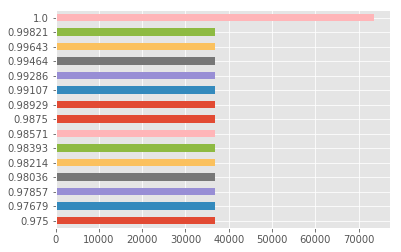

In [25]:
# split of data based on coefficient 'GT_Turb_Decay_coeff'
coeff_groups = df.GT_Turb_Decay_coeff.value_counts().sort_index()
coeff_groups.plot(kind="barh");

# Binary Classfication - Logistic Regression

In [0]:
# filter to split last column in two-classes
filt = (df.GT_Turb_Decay_coeff.values >= 0.98900)
df.loc[filt, 'Target_Decay'] = 0    # equipment @ 100% capacity
df.loc[~filt, 'Target_Decay'] = 1   # equipment below 100% capacity

# remove '_coeff' columns from dataset
df.drop(columns=['Prop_Thrs_Decay_coeff', 'Prop_Trq_Decay_coeff', 
                 'Hull_Decay_coeff', 'GT_Compr_Decay_coeff', 
                 'GT_Turb_Decay_coeff'])

# create numeric arrays from dataframe
X = df.loc[:, 'Lever_lp':'Prop_Trq'].values
y = df.Target_Decay.values

In [0]:
# split dataset in train, test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=123)
num_features = X_train.shape[1]
num_train_obs = X_train.shape[0]
num_test_obs = X_test.shape[0]

In [12]:
"""
Set up the logistic regression model
"""

model = Sequential(
    [
        Dense(
            128, 
            activation='relu',
            # input dim = number of features our data has
            input_dim=num_features
        ),
        Dense(
            64, 
            activation='relu'
        ),
        Dense(
            2, 
            activation='softmax', 
            kernel_regularizer=L1L2(l1=0.0, l2=0.1)
        )
    ]
)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# compile model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [14]:
# summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3328      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 11,714
Trainable params: 11,714
Non-trainable params: 0
_________________________________________________________________


In [0]:
# scale dataset on X_train, X_test
scaler = StandardScaler()

# scaler get mu, std from X_train
X_train = scaler.fit_transform(X_train)
# transform X_test using scaler
X_test = scaler.transform(X_test)

In [0]:
# learn the model
model.fit(
    X_train, y_train, epochs=50, verbose=2 
)

In [17]:
# Score trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

117845/117845 [==============================] - 2s 17us/step
Test loss: 0.10994998279656597
Test accuracy: 0.9449616021044592


[0.08804655458878194, 0.9709109423395138]

In [0]:
names = list(model.history.history.keys())
values = list(model.history.history.values())

In [0]:
# x-axis sequence
xp = np.arange(len(values[0]))

In [0]:
# plot loss, accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(xp, values[0]) # loss
plt.plot(xp, values[1]) # accuracy
plt.legend(names);

# Multi-Class Classification

In [46]:
df.GT_Turb_Decay_coeff.value_counts().sort_index(ascending=False).index

Float64Index([    1.0, 0.99821, 0.99643, 0.99464, 0.99286, 0.99107, 0.98929,
               0.9875, 0.98571, 0.98393, 0.98214, 0.98036, 0.97857, 0.97679,
                0.975],
             dtype='float64')

In [0]:
# filter to split last column in 4-classes
# class 0: healthy function
filt0 = (df.GT_Turb_Decay_coeff.values >= 0.99600)
# class 1: below healthy function
filt1 = (df.GT_Turb_Decay_coeff.values < 0.99600) & \
        (df.GT_Turb_Decay_coeff.values >= 0.98900)
# class 2: concerning functioning
filt2 = (df.GT_Turb_Decay_coeff.values < 0.98900) & \
        (df.GT_Turb_Decay_coeff.values >= 0.98200)
# class 3: critical functioning
filt3 = (df.GT_Turb_Decay_coeff.values < 0.98200)


df.loc[filt0, 'Target_Decay'] = 0    # equipment @ 100% capacity
df.loc[filt1, 'Target_Decay'] = 1    # equipment below 100% capacity
df.loc[filt2, 'Target_Decay'] = 2    # equipment under concerning operation
df.loc[filt3, 'Target_Decay'] = 3    # equipment under critical operation

In [0]:
# remove '_coeff' columns from dataset
df.drop(columns=['Prop_Thrs_Decay_coeff', 'Prop_Trq_Decay_coeff', 
                 'Hull_Decay_coeff', 'GT_Compr_Decay_coeff', 
                 'GT_Turb_Decay_coeff'], inplace=True)

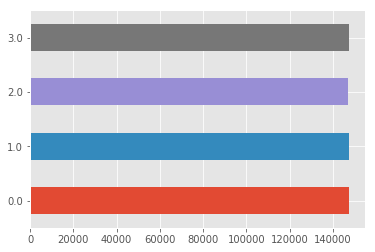

In [50]:
df.Target_Decay.value_counts().sort_index().plot(kind='barh')

In [0]:
# create numeric arrays from dataframe
X = df.loc[:, 'Lever_lp':'Prop_Trq'].values
y = df.Target_Decay.values

In [53]:
# raw X: not scaled
print(X[:3])

[[1.1379e+00 3.0000e+00 7.2525e+03 1.3576e+03 7.8001e+00 7.8001e+00
  4.0835e+04 5.9448e+01 4.0835e+04 5.9448e+01 6.2667e+02 6.6687e+03
  2.9895e-01 8.9076e+00 7.1370e+00 5.6777e+02 1.0193e+00 1.3313e+00
  1.3746e+01 1.6701e-02 9.9080e-01 1.6701e-02 9.9080e-01 2.6763e+04
  2.6763e+04]
 [2.0883e+00 6.0000e+00 3.9199e+03 1.3788e+03 2.7759e+01 2.7759e+01
  6.2949e+04 6.0379e+01 6.2949e+04 6.0379e+01 4.9723e+02 6.8282e+03
  1.3086e-01 9.2824e+00 6.6000e+00 5.5611e+02 1.0200e+00 1.2416e+00
  2.0249e+00 5.4159e-02 1.0063e+00 5.4159e-02 1.0063e+00 4.5078e+04
  4.5078e+04]
 [3.1438e+00 9.0000e+00 9.4465e+03 1.3867e+03 5.8429e+01 5.8429e+01
  1.0787e+05 6.0725e+01 1.0787e+05 6.0725e+01 5.7108e+02 7.1417e+03
  2.3766e-01 1.1925e+01 7.6004e+00 5.7686e+02 1.0209e+00 1.4260e+00
  1.2005e+01 1.1063e-01 1.0121e+00 1.1063e-01 1.0121e+00 8.4240e+04
  8.4240e+04]]


In [63]:
# raw y: not scaled
print(y[:3])

[0. 0. 0.]


In [0]:
# split dataset in train, test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=123)
num_features = X_train.shape[1]

In [0]:
"""
Set up the Multi-Class classification model
"""

model = Sequential(
    [
        Dense(
            128, 
            activation='relu',
            # input dim = number of features our data has
            input_dim=num_features
        ),
        Dense(
            64, 
            activation='relu'
        ),
        Dense(
            4, 
            activation='softmax', 
            kernel_regularizer=L1L2(l1=0.01, l2=0.1)
        )
    ]
)

In [0]:
# compile model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [68]:
# summary of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               3328      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 11,844
Trainable params: 11,844
Non-trainable params: 0
_________________________________________________________________


In [0]:
# scale dataset on X_train, X_test
scaler = StandardScaler()

# scaler get mu, std from X_train
X_train = scaler.fit_transform(X_train)
# transform X_test using scaler
X_test = scaler.transform(X_test)

In [70]:
# learn the model
model.fit(
    X_train, y_train, epochs=50, verbose=2
)

Epoch 1/50
 - 17s - loss: 0.9411 - acc: 0.6171
Epoch 2/50
 - 17s - loss: 0.6419 - acc: 0.7616
Epoch 3/50
 - 17s - loss: 0.5678 - acc: 0.7856
Epoch 4/50
 - 16s - loss: 0.5266 - acc: 0.8003
Epoch 5/50
 - 16s - loss: 0.4959 - acc: 0.8166
Epoch 6/50
 - 16s - loss: 0.4716 - acc: 0.8305
Epoch 7/50
 - 16s - loss: 0.4480 - acc: 0.8428
Epoch 8/50
 - 16s - loss: 0.4275 - acc: 0.8527
Epoch 9/50
 - 16s - loss: 0.4061 - acc: 0.8658
Epoch 10/50
 - 17s - loss: 0.3818 - acc: 0.8866
Epoch 11/50
 - 16s - loss: 0.3582 - acc: 0.9048
Epoch 12/50
 - 16s - loss: 0.3383 - acc: 0.9154
Epoch 13/50
 - 16s - loss: 0.3216 - acc: 0.9233
Epoch 14/50
 - 16s - loss: 0.3065 - acc: 0.9302
Epoch 15/50
 - 16s - loss: 0.2941 - acc: 0.9342
Epoch 16/50
 - 16s - loss: 0.2843 - acc: 0.9377
Epoch 17/50
 - 16s - loss: 0.2717 - acc: 0.9419
Epoch 18/50
 - 16s - loss: 0.2636 - acc: 0.9440
Epoch 19/50
 - 16s - loss: 0.2526 - acc: 0.9482
Epoch 20/50
 - 16s - loss: 0.2435 - acc: 0.9509
Epoch 21/50
 - 17s - loss: 0.2366 - acc: 0.9528
E

In [71]:
# Score trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

117845/117845 [==============================] - 2s 20us/step
Test loss: 0.09741523329036895
Test accuracy: 0.9936951079808223


In [0]:
names = list(model.history.history.keys())
values = list(model.history.history.values())

In [0]:
# x-axis sequence
xp = np.arange(len(values[0]))

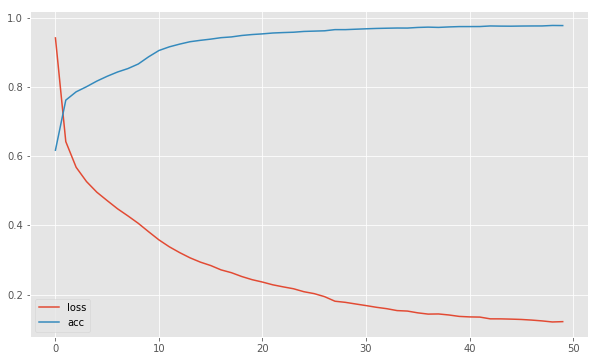

In [74]:
# plot loss, accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(xp, values[0]) # loss
plt.plot(xp, values[1]) # accuracy
plt.legend(names);